In [123]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# %matplotlib 

## Transformada de Fourier en 2D
Podemos interpretar los cambios de intensidad de la imagen como funciones sobre un plano

![SNOWFALL](fourier.png)

In [124]:
# Leemos ambas imagenes
img_low_freq = cv2.imread('fft_hf.jpg', cv2.IMREAD_GRAYSCALE)
img_hig_freq = cv2.imread('fft_lf.jpg', cv2.IMREAD_GRAYSCALE)
# Aplico la transformada
img_fft_low = np.fft.fft2(img_low_freq)
img_fft_hig = np.fft.fft2(img_hig_freq)
# llevo la baja frec al origen para acomodar la visualizacion
img_fft_low = np.fft.fftshift(img_fft_low)
img_fft_hig = np.fft.fftshift(img_fft_hig)
# obtengo el modulo
img_fft_low = 20*np.log(np.abs(img_fft_low))
img_fft_hig = 20*np.log(np.abs(img_fft_hig))
# Tomamos un "perfil" de una fila por cada imagen
low_freq_sg = img_low_freq[50,10:60]
hig_freq_sg = img_hig_freq[50,10:60]

Graficamos los resultados

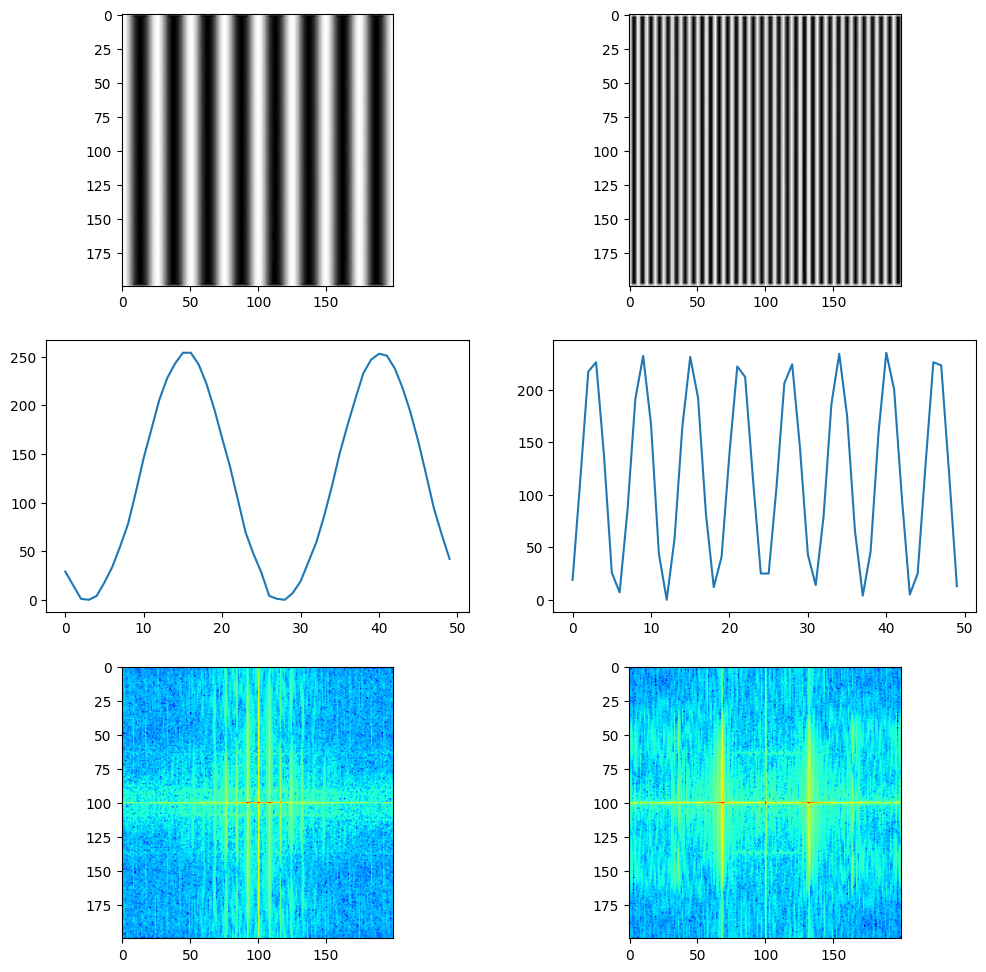

In [125]:
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(img_low_freq, cmap='gray')
plt.subplot(3,2,2)
plt.imshow(img_hig_freq, cmap='gray')

plt.subplot(3,2,3)
plt.plot(low_freq_sg)
plt.subplot(3,2,4)
plt.plot(hig_freq_sg)

plt.subplot(3,2,5)
plt.imshow(img_fft_low, cmap='jet')
plt.subplot(3,2,6)
plt.imshow(img_fft_hig, cmap='jet')

## Filtros en el dominio espectral

In [127]:
# funciones auxiliares
def fft2_mod(image):

  shifted_image_fft = np.fft.fftshift(np.fft.fft2(image))

  return 20*np.log(np.abs(shifted_image_fft))


def _filter_round_shape(height, width, radius):
  canvas = np.zeros((height, width))
  return cv2.circle(canvas,
                     center=(int(canvas.shape[1]/2), int(canvas.shape[0]/2)),
                     radius=radius,
                     color=(255),
                     thickness=-1).astype(np.uint8)


def create_lp_filter(height, width, radius=20):

  lp_filter = _filter_round_shape(height, width, radius)
  return lp_filter


def create_hp_filter(height, width, radius=60):

  lp_filter = _filter_round_shape(height, width, radius)
  return cv2.bitwise_not(lp_filter)

In [128]:
# leo la imagen en escala de grises
img = cv2.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)
# obtengo el modulo de la transformada de fourier
mod = fft2_mod(img)

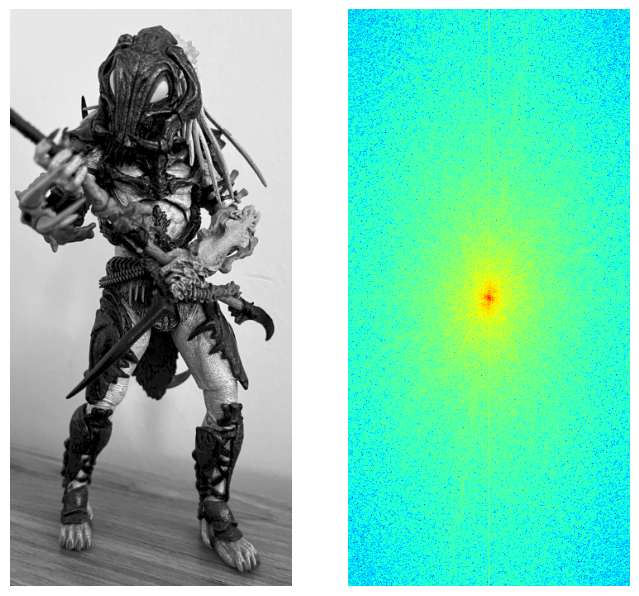

In [129]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(mod, cmap='jet')

### Definimos los filtros en el dominio espectral

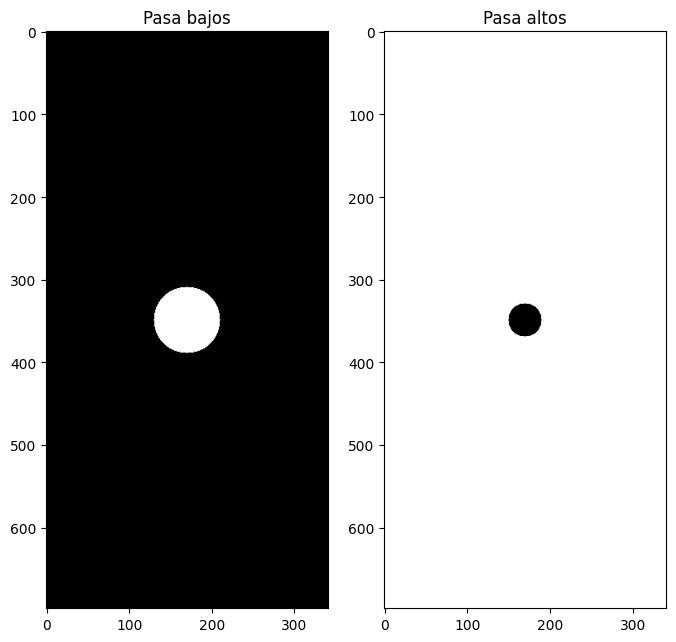

In [130]:
h, w = img.shape
lp_filter = create_lp_filter(h, w, radius=40)
hp_filter = create_hp_filter(h, w, radius=20)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(lp_filter, cmap='gray')
plt.title('Pasa bajos')
plt.subplot(1,2,2)
plt.title('Pasa altos')
plt.imshow(hp_filter, cmap='gray')

### Aplicamos los filtros a la imagen

In [131]:
# vuelvo a calcular la FFT. Para aplicar el filtro 
# necesito la transformada en modulo y fase en el dominio
# de los numeros complejos
shifted_fft = np.fft.fftshift(np.fft.fft2(img))
lp_filtered = shifted_fft * lp_filter
hp_filtered = shifted_fft * hp_filter

# Aplicamos la antitransformada y obtenemos las imagenes filtradas
f_ishift = np.fft.ifftshift(lp_filtered)
img_lp = np.real(np.fft.ifft2(f_ishift))
f_ishift = np.fft.ifftshift(hp_filtered)
img_hp = np.real(np.fft.ifft2(f_ishift))

### Graficamos los resultados

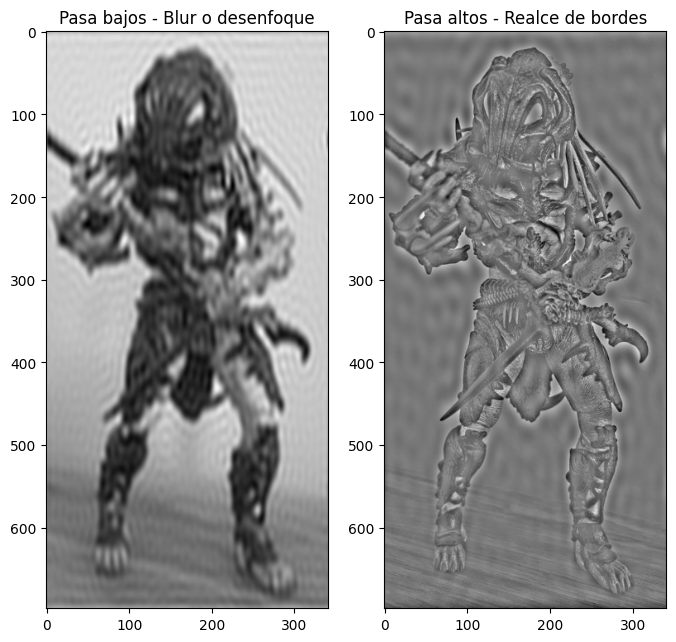

In [132]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(img_lp, cmap='gray')
plt.title('Pasa bajos - Blur o desenfoque')
plt.subplot(1,2,2)
plt.title('Pasa altos - Realce de bordes')
plt.imshow(img_hp, cmap='gray')

La función create_gauss_filter(h, w, k_size=5, sigma=5) crea un filtro Gaussiano de tamaño h x w en el dominio espacial y también calcula su Transformada de Fourier.

El filtro Gaussiano se crea calculando la distribución Gaussiana para cada píxel en el filtro, centrada en el píxel central del filtro. La distribución Gaussiana se calcula como np.exp(-((i - center_h) ** 2 + (j - center_w) ** 2) / (2 * sigma ** 2)), donde i y j son las coordenadas del píxel, center_h y center_w son las coordenadas del centro del filtro, y sigma es el valor de sigma para la distribución Gaussiana.

Después de calcular la distribución Gaussiana para cada píxel, el filtro se normaliza dividiéndolo por la suma de todos los valores en el filtro. Esto asegura que la suma de todos los valores en el filtro sea 1, lo cual es una propiedad de la distribución Gaussiana.

Finalmente, se calcula la Transformada de Fourier del filtro utilizando la función np.fft.fft2(filter). Esto convierte el filtro del dominio espacial al dominio de la frecuencia.

La función devuelve tanto el filtro Gaussiano en el dominio espacial como su Transformada de Fourier.

In [133]:
def create_gauss_filter(h, w, k_size=5, sigma=5):
    """
    Creates a Gaussian filter with the specified height, width, kernel size, and sigma value.
    
    Parameters:
    - h (int): Height of the filter.
    - w (int): Width of the filter.
    - k_size (int): Size of the kernel (default: 5).
    - sigma (int): Sigma value for the Gaussian distribution (default: 5).
    
    Returns:
    - filter (ndarray): Gaussian filter.
    - filter_tf (ndarray): Fourier transform of the Gaussian filter.
    """
    # Calculate the center coordinates of the filter
    center_h = h // 2
    center_w = w // 2
    
    # Create an empty filter
    filter = np.zeros((h, w))
    
    # Calculate the Gaussian distribution values for each pixel in the filter
    for i in range(h):
        for j in range(w):
            filter[i, j] = np.exp(-((i - center_h) ** 2 + (j - center_w) ** 2) / (2 * sigma ** 2))
    
    # Normalize the filter
    filter /= np.sum(filter)
    
    # Calculate the Fourier transform of the filter
    filter_tf = np.fft.fft2(filter)
    
    return filter, filter_tf

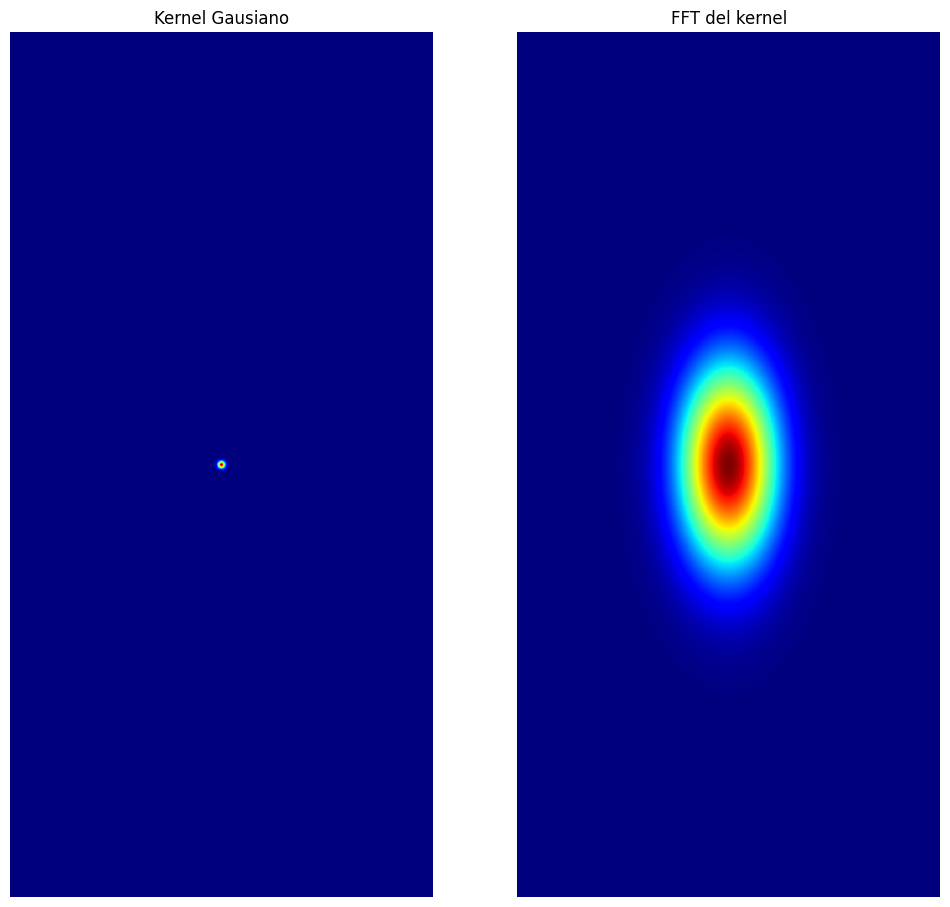

In [134]:
kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=2)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
tf_shifted = np.fft.fftshift(kernel_tf)
plt.imshow(np.abs(tf_shifted), cmap='jet')

Text(0.5, 1.0, 'Desenfoque gausiano')

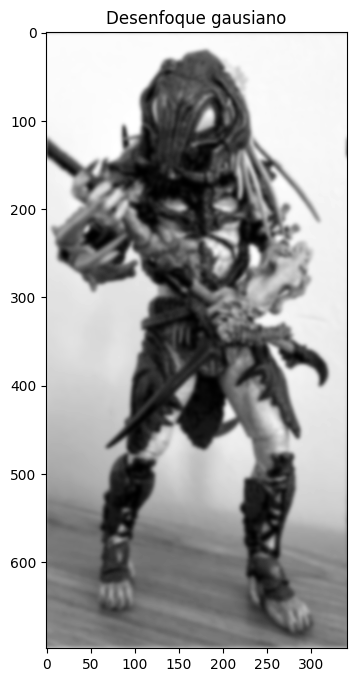

In [135]:
img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_tf

img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

plt.figure(figsize=(8,8))
plt.imshow(img_gauss, cmap='gray')
plt.title('Desenfoque gausiano')

Primero, necesitamos un plan para abordar esta tarea:

1. Definir los diferentes tamaños de kernel y valores de sigma que queremos probar.
2. Para cada combinación de tamaño de kernel y sigma:
    - Crear el filtro Gaussiano y su Transformada de Fourier utilizando la función create_gauss_filter().
    - Graficar el filtro Gaussiano y su Transformada de Fourier.
    - Aplicar el filtro Gaussiano a una imagen en el dominio espectral.
    - Graficar la imagen filtrada.
3. Mostrar todas las gráficas.

Los valores de sigma suelen estar en el rango de 0.1 a 10. Un valor de sigma más pequeño (como 0.1, 0.5, o 1) resultará en un desenfoque más ligero, mientras que un valor de sigma más grande (como 5, 7, o 10) resultará en un desenfoque más fuerte.

In [136]:
# Adjust the kernel size and sigma values
sigma_values = [0.5, 1, 2, 3, 5]

Tamaño del kernel (k_size): Los valores comúnmente utilizados para el tamaño del kernel son números impares que van desde 3 hasta 31. Los valores más pequeños (como 3, 5, o 7) se utilizan para suavizar ligeramente la imagen y eliminar el ruido de alta frecuencia, mientras que los valores más grandes (como 15, 21, o 31) se utilizan para un suavizado más fuerte.

In [137]:
# Define the different kernel sizes and sigma values
k_size = 5

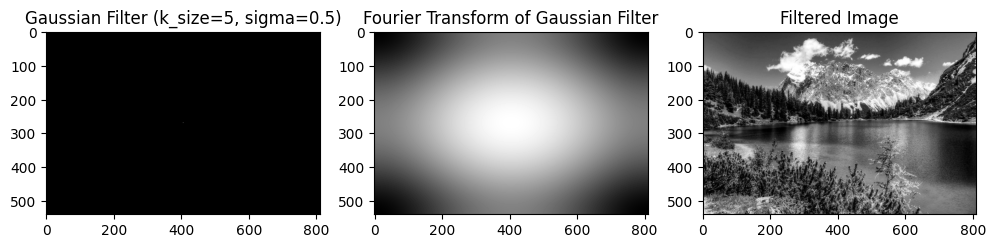

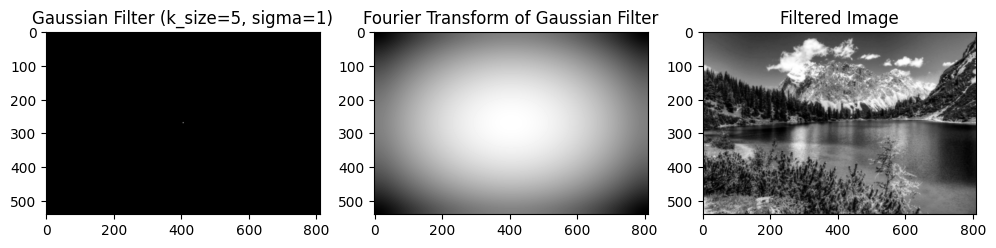

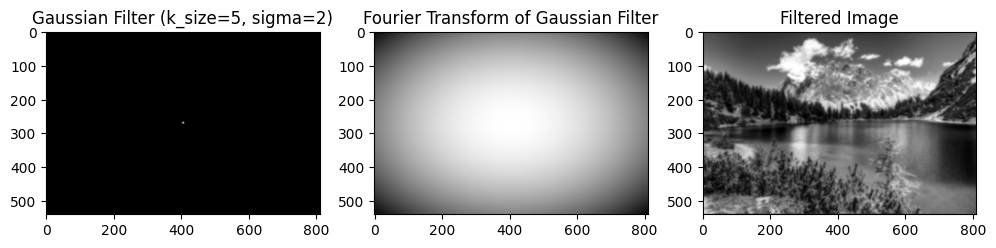

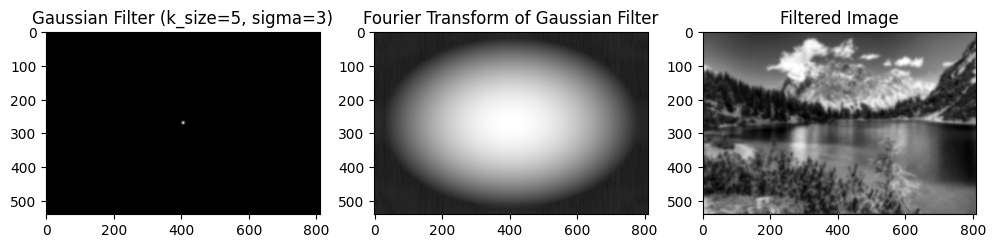

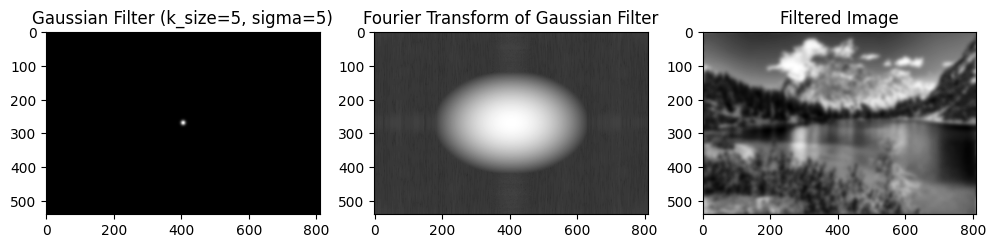

In [138]:
# Load the image
img = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)
assert img is not None, "Image could not be read. Check the path and try again."

# Fourier transform of the image
img_tf = np.fft.fft2(img)

# # For each combination of kernel size and sigma
# for k_size in kernel_sizes:
for sigma in sigma_values:
    # Create the Gaussian filter and its Fourier transform
    gauss_filter, gauss_filter_tf = create_gauss_filter(img.shape[0], img.shape[1], k_size, sigma)
    
    # Shift the zero-frequency component to the center for both image and filter
    img_tf_shifted = np.fft.fftshift(img_tf)
    gauss_filter_tf_shifted = np.fft.fftshift(gauss_filter_tf)
    
    # Apply the Gaussian filter to the image in the spectral domain
    img_filtered_tf = img_tf_shifted * gauss_filter_tf_shifted
    
    # Apply the inverse Fourier transform
    img_filtered = np.fft.ifft2(img_filtered_tf)
    
    # Shift the zero-frequency component back to the center
    img_filtered = np.fft.fftshift(img_filtered)
    
    # Plot the Gaussian filter and its Fourier transform
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(gauss_filter, cmap='gray')
    plt.title(f'Gaussian Filter (k_size={k_size}, sigma={sigma})')
    plt.subplot(132)
    plt.imshow(np.log(np.abs(gauss_filter_tf_shifted)), cmap='gray')
    plt.title('Fourier Transform of Gaussian Filter')
    
    # Plot the filtered image
    plt.subplot(133)
    plt.imshow(np.abs(img_filtered), cmap='gray')
    plt.title('Filtered Image')
    plt.show()

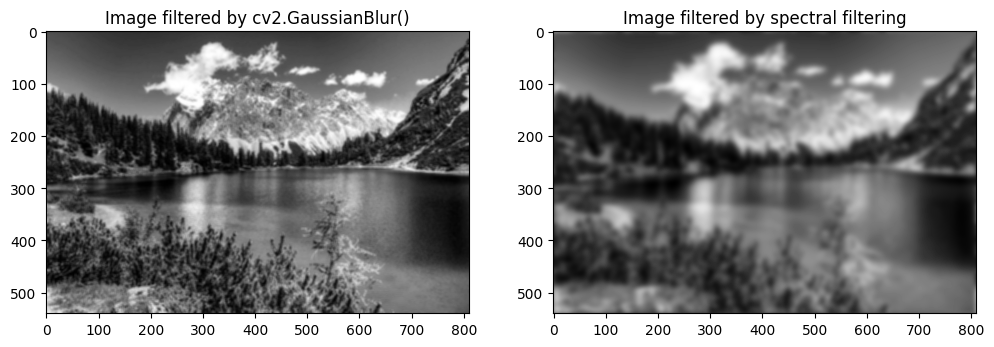

Mean squared error: 226.5596537809598


In [140]:
# # Apply the Gaussian filter to the image using convolution
# gauss_filter = cv2.getGaussianKernel(k_size, sigma)
# gauss_filter = gauss_filter * gauss_filter.T
# img_filtered_conv = cv2.filter2D(img, -1, gauss_filter)
img_filtered_conv = cv2.GaussianBlur(img, (k_size, k_size), sigma)
# img_filtered_conv = cv2.GaussianBlur(img, (k_size, k_size), sigma)

# Apply the Gaussian filter to the image using spectral filtering
# (This is the same code as before)
gauss_filter, gauss_filter_tf = create_gauss_filter(img.shape[0], img.shape[1], k_size, sigma)
img_tf_shifted = np.fft.fftshift(img_tf)
gauss_filter_tf_shifted = np.fft.fftshift(gauss_filter_tf)
img_filtered_tf = img_tf_shifted * gauss_filter_tf_shifted
img_filtered_spectral = np.fft.ifft2(img_filtered_tf)
img_filtered_spectral = np.fft.fftshift(img_filtered_spectral)

# Compare the two filtered images
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(img_filtered_conv, cmap='gray')
plt.title('Image filtered by cv2.GaussianBlur()')
plt.subplot(122)
plt.imshow(np.abs(img_filtered_spectral), cmap='gray')
plt.title('Image filtered by spectral filtering')
plt.show()

# Calculate the mean squared error between the two filtered images
mse = np.mean((img_filtered_conv - np.abs(img_filtered_spectral)) ** 2)
print(f'Mean squared error: {mse}')

In [141]:
def image_quality_measure(img):
    # Step 1: Compute F which is the Fourier Transform representation of image I
    F = np.fft.fft2(img)
    
    # Step 2: Find Fc which is obtained by shifting the origin of F to centre.
    Fc = np.fft.fftshift(F)
    
    # Step 3: Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I.
    AF = np.abs(Fc)
    
    # Step 4: Calculate M = max (AF) where M is the maximum value of the frequency component in F.
    M = np.max(AF)
    
    # Step 5: Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000.
    thres = M / 1000
    TH = np.sum(AF > thres)
    
    # Step 6: Calculate Image Quality measure (FM) from equation (1).
    # Image Quality Measure (FM) = TH/M*N.
    FM = TH / (M * img.size)
    
    return FM

In [142]:
# Load the image
img = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)

In [143]:
# def apply_gaussian_filter_conv(img, k_size, sigma):
#     gauss_filter = cv2.getGaussianKernel(k_size, sigma)
#     gauss_filter = gauss_filter * gauss_filter.T
#     img_filtered = cv2.filter2D(img, -1, gauss_filter)
#     return img_filtered

def apply_gaussian_filter_spectral(img, k_size, sigma):
    gauss_filter, gauss_filter_tf = create_gauss_filter(img.shape[0], img.shape[1], k_size, sigma)
    img_tf_shifted = np.fft.fftshift(img_tf)
    gauss_filter_tf_shifted = np.fft.fftshift(gauss_filter_tf)
    img_filtered_tf = img_tf_shifted * gauss_filter_tf_shifted
    img_filtered = np.fft.ifft2(img_filtered_tf)
    img_filtered = np.fft.fftshift(img_filtered)
    return img_filtered

def calculate_image_quality(img_filtered_conv, img_filtered_spectral):
    conv_result = image_quality_measure(img_filtered_conv)
    spectral_result = image_quality_measure(np.abs(img_filtered_spectral))
    return conv_result, spectral_result

def plot_results(k_size, sigma_values, conv_results, spectral_results):
    plt.figure(figsize=(10, 6))
    plt.plot(sigma_values, conv_results, label='Convolution')
    plt.plot(sigma_values, spectral_results, label='Spectral filtering')
    for i, sigma in enumerate(sigma_values):
        plt.text(sigma, conv_results[i], f'{sigma}', ha='center')
        plt.text(sigma, spectral_results[i], f'{sigma}', ha='center')
    plt.xlabel('Sigma')
    plt.ylabel('Image Quality Measure')
    plt.title(f'Kernel Size = {k_size}')
    plt.legend()
    plt.show()

In [144]:
def process_images(img, k_size_values, sigma_values):
    for k_size in k_size_values:
        conv_results = []
        spectral_results = []
        for sigma in sigma_values:
            img_filtered_conv = cv2.GaussianBlur(img, (k_size, k_size), sigma)
            img_filtered_spectral = apply_gaussian_filter_spectral(img, k_size, sigma)
            conv_result, spectral_result = calculate_image_quality(img_filtered_conv, img_filtered_spectral)
            conv_results.append(conv_result)
            spectral_results.append(spectral_result)
        plot_results(k_size, sigma_values, conv_results, spectral_results)

In [145]:
k_size_values = [3, 5, 7, 9, 11]

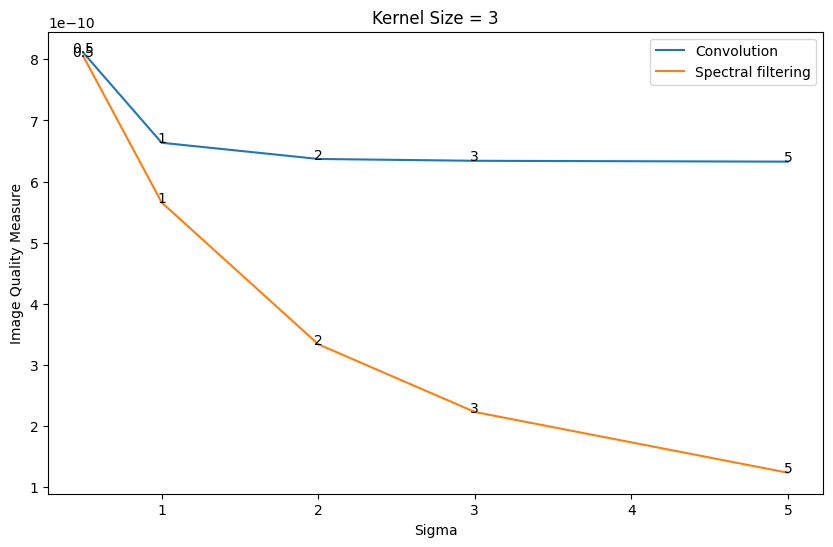

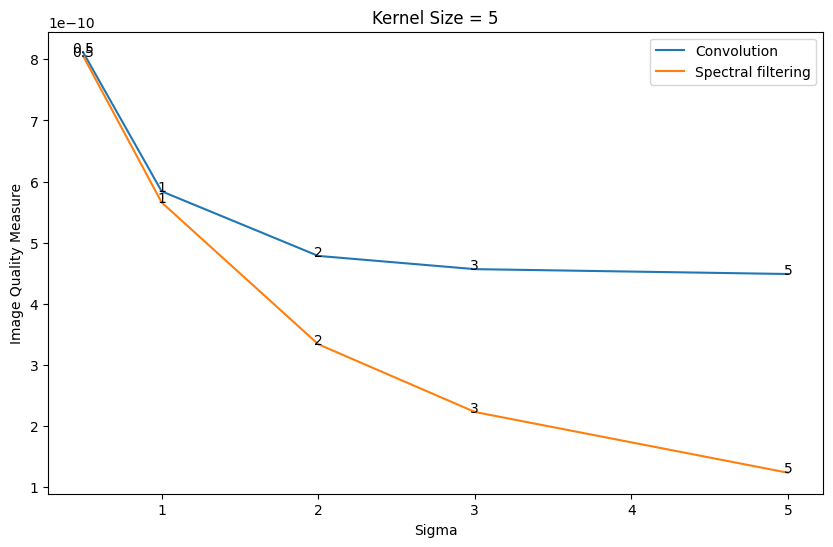

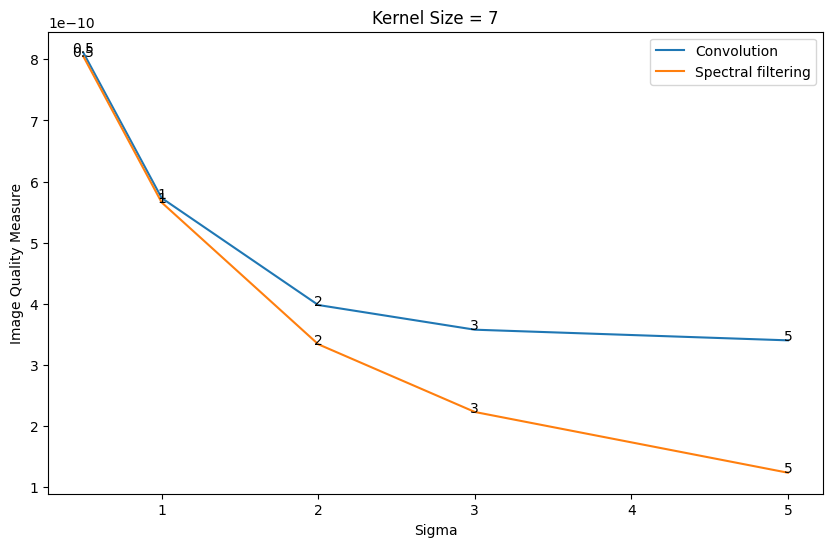

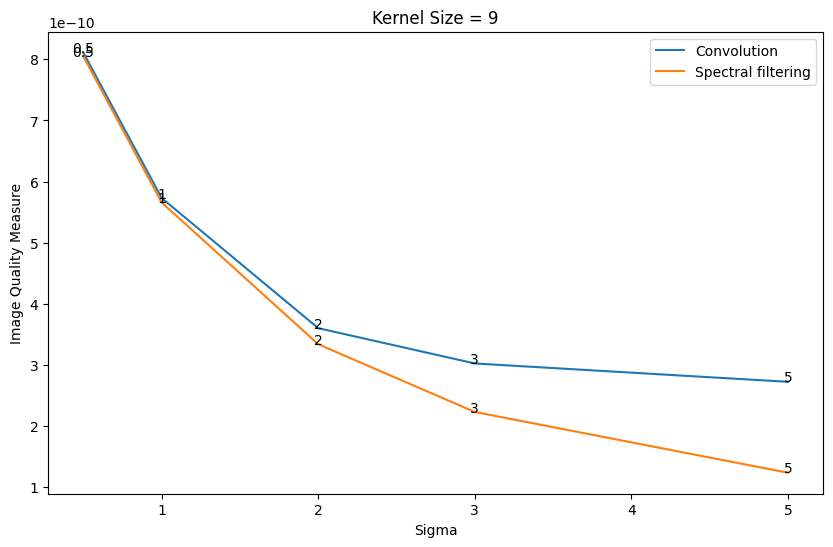

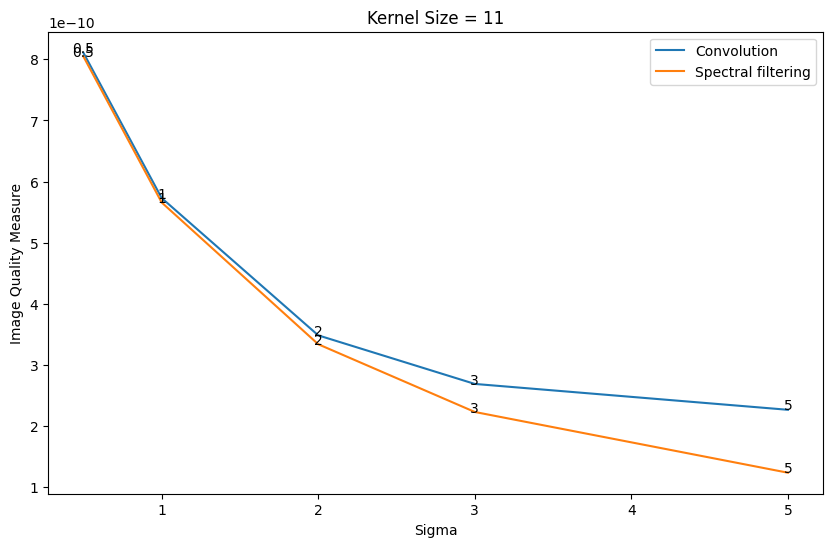

In [146]:
# process_images(img, [k_size], sigma_values)
process_images(img, k_size_values, sigma_values)

# 3

La medida de enfoque de Brenner se basa en la segunda diferencia de los niveles de gris de una imagen. 

In [147]:
def brenner_focus_measure(img):
    # Calculate the second difference of the image gray-levels
    img_shifted = np.roll(img, 2, axis=0)  # Shift the image by 2 pixels in the x direction
    second_diff = (img - img_shifted) ** 2  # Calculate the second difference
    # Sum the squared second difference
    focus_measure = np.sum(second_diff)
    return focus_measure

In [148]:
def calculate_image_quality(img_filtered_conv, img_filtered_spectral):
    conv_result = brenner_focus_measure(img_filtered_conv)
    spectral_result = brenner_focus_measure(np.abs(img_filtered_spectral))
    return conv_result, spectral_result

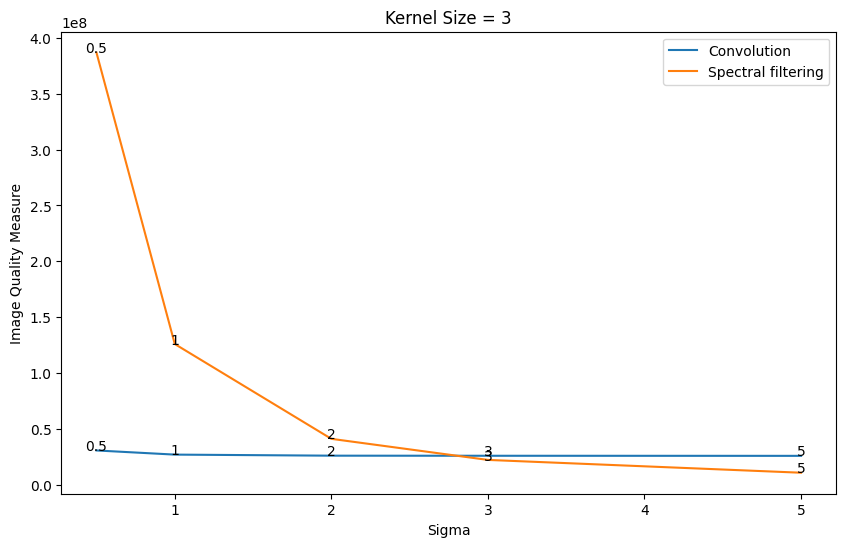

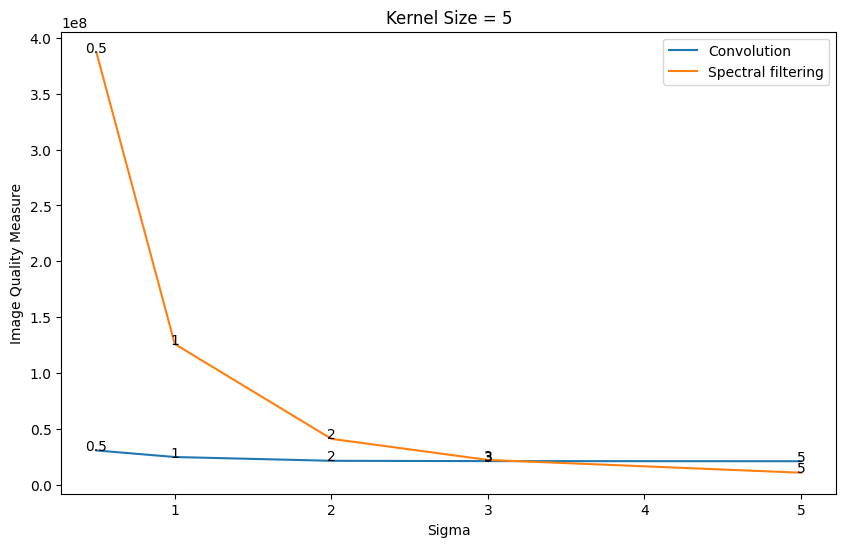

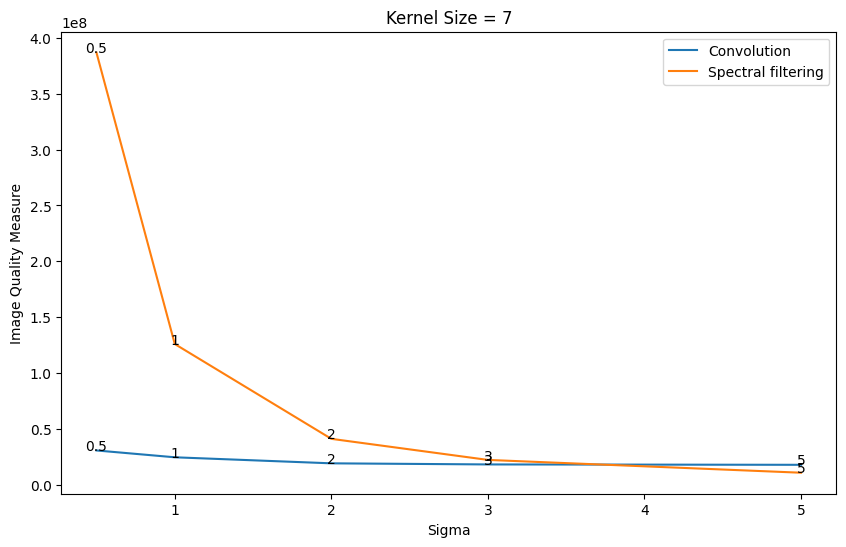

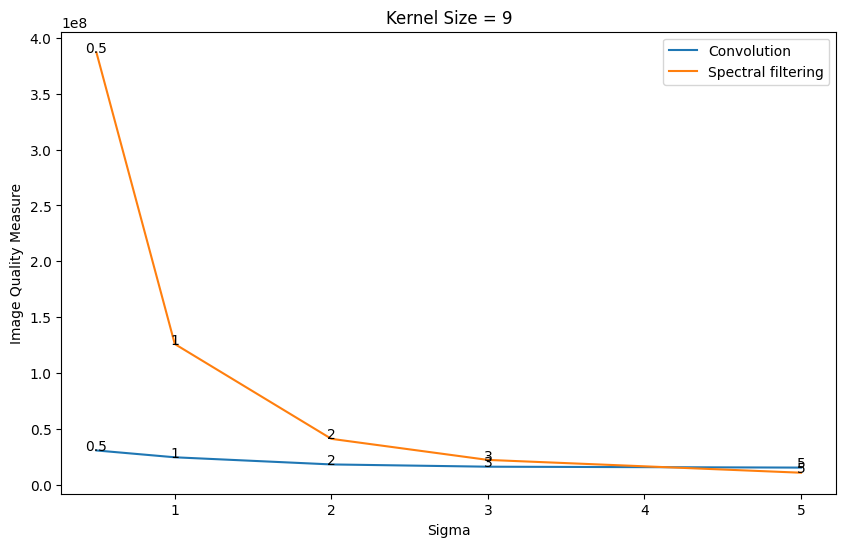

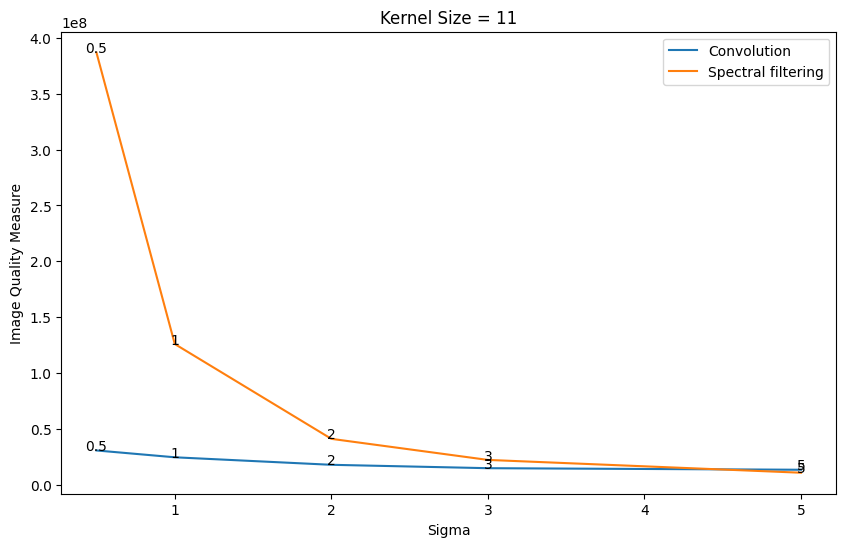

In [149]:
# Define the image, kernel sizes, and sigma values
# img = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)  # replace 'path_to_your_image' with the path to your image
# k_size_values = [3, 5, 7]  # replace with the kernel sizes you want to use
# sigma_values = [0.5, 1.0, 1.5]  # replace with the sigma values you want to use

# Call the process_images function
process_images(img, k_size_values, sigma_values)

# FIN

# ---------------------------------------

La parte practica termina aca. El siguiente codigo corresponde a practicas.

In [14]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

img = cv.imread('lineas1.jpg', cv.IMREAD_GRAYSCALE)

Text(0.5, 1.0, 'Imagen original')

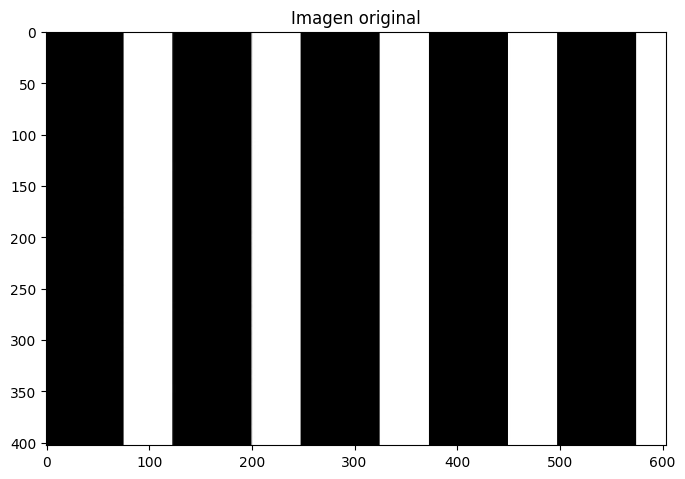

In [15]:
#show image
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.title('Imagen original')

In [16]:
# aplica la función np.fft.fft2() de la biblioteca NumPy para calcular la Transformada de Fourier.
fourier = np.fft.fft2(img)

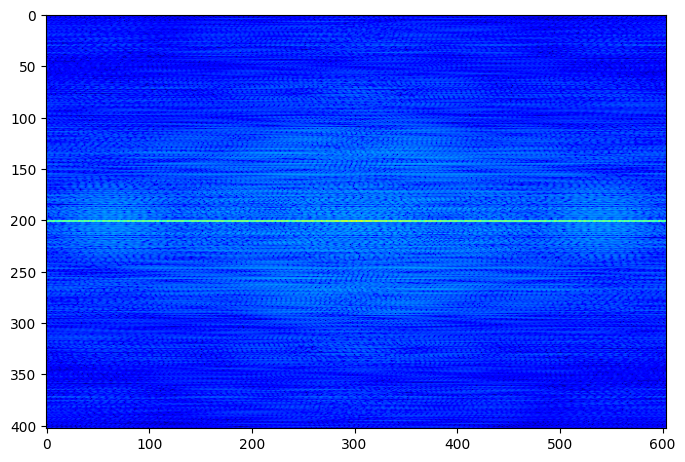

In [17]:
# visualizar la imagen
plt.figure(figsize=(8,8))
fourier = np.fft.fftshift(np.log(1+np.abs(fourier)))
plt.imshow(fourier, cmap='jet')

(Text(0.5, 1.0, 'Magnitude Spectrum'), ([], []), ([], []))

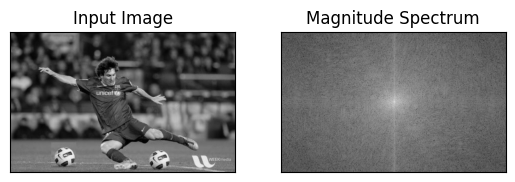

In [18]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
 
img = cv.imread('messi5.jpg', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
 
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

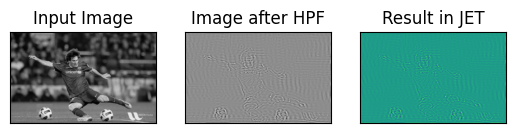

In [19]:
rows, cols = img.shape
crow, ccol = rows//2, cols//2
fshift[crow-30:crow+31, ccol-30:ccol+31] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.real(img_back)
 
plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_back)
plt.title('Result in JET'), plt.xticks([]), plt.yticks([])
 
plt.show()